In [1]:
import numpy as np 
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
from statistics import mean 
import copy
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(11,8)})
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
plt.rcParams["axes.grid"] = False
import gc
import os
import math
from numba import njit
from numpy import sqrt, sin, cos, pi, zeros
from numpy.random import randn, rand, uniform, normal
from scipy.linalg import hadamard
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Embedding, Reshape, Dot, Concatenate
from tensorflow.keras.layers import GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,Multiply, Lambda, Softmax, Flatten, BatchNormalization, Bidirectional, dot, concatenate
from tensorflow.keras.layers import AdditiveAttention, Attention
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

/kaggle/input/lottery/lottery.csv
/kaggle/input/lottery-dataset-with-dates/addeddates.csv


## LSTM (Long short term memory)

## What is LSTM?

### In short, LSTM is a deep learning model that is affected by previous events in the time series and can capture a time-related pattern in the data to make predictions. Because of that I choosed LSTM.

Since lottery sequences are dependent events, are we able to find somekind of pattern that will explain the sequence?
Do different lottery draws affect the result of the upcoming draw? (Will keep this one for another kernel)
Having set up our main concerns, we know that RNNs are well performing in temporal (time based) data applications.
Well, you have your answer.

In [2]:
lottery_ml = pd.read_csv("/kaggle/input/lottery/lottery.csv")

In [3]:
lottery_ml.drop(['sum','Unnamed: 0'],axis=1,inplace=True)

In [4]:
lottery_ml

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5
0,12,18,20,31,38
1,12,22,42,43,53
2,3,11,44,47,58
3,18,22,23,41,53
4,12,25,31,33,58
...,...,...,...,...,...
1300,13,23,37,57,60
1301,2,21,30,48,58
1302,5,14,48,41,57
1303,6,20,21,34,49


In [6]:
# Normalizing and downscaling the data such that mean per column is 0
scaler = StandardScaler().fit(lottery_ml.values)
transformed_dataset = scaler.transform(lottery_ml.values)
lottery_ml_normalized = pd.DataFrame(data=transformed_dataset, index=lottery_ml.index)
lottery_ml_normalized

,0,1,2,3,4
0,0.197096,-0.226938,-0.943931,-0.882120,-1.522883
1,0.197096,0.159308,1.048882,0.238509,0.279005
2,-0.895348,-0.902870,1.230047,0.612053,0.879634
3,0.925391,0.159308,-0.672184,0.051738,0.279005
4,0.197096,0.448993,0.052475,-0.695348,0.879634
...,...,...,...,...,...
1300,0.318478,0.255870,0.595970,1.545910,1.119886
1301,-1.016730,0.062747,-0.038107,0.705438,0.879634
1302,-0.652583,-0.613185,1.592376,0.051738,0.759508
1303,-0.531200,-0.033815,-0.853349,-0.601963,-0.201498


In [7]:
rows_to_retain_for_test = 250
number_of_rows= lottery_ml.values.shape[0] - rows_to_retain_for_test
games_window_size = 50 #amount of past games we need to take in consideration for training (It's also the number of draws)
number_of_features = lottery_ml.values.shape[1] #balls count

In [8]:
#Number of rows = number of games to train (samples)
#Number of columns = Number of previous games (timestep)
#Number of depths = Number of features (in this case on 7 balls) (features)
train = np.empty([number_of_rows-games_window_size, games_window_size, number_of_features], dtype=float)
label = np.empty([number_of_rows-games_window_size, number_of_features], dtype=float)


# train represents the training data
# label represents the expected result

#train[2][0][5] holds the value of ball 6 (or feature number 6) in previous game 0 (that means the current game) which is actually game number 1.
#train[200][4][3] holds the value of ball 4 (or feature number 4) in previous game 4 (that means 4 games before the current draw) where the current draw is 199.

#Think about it as a row based visualization

#For each row ==> Technically we can say that every row is a training batch

for i in range(0, number_of_rows-games_window_size):
    train[i]=lottery_ml_normalized.iloc[i:i+games_window_size, 0: number_of_features]
    # the label will have the result of the next draw.
    label[i]=lottery_ml_normalized.iloc[i+games_window_size: i+games_window_size + 1, 0: number_of_features]

In [9]:
model = Sequential()
model.add(LSTM(200, input_shape=(games_window_size, number_of_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(number_of_features))
model.compile(loss='mse', optimizer='rmsprop', metrics=["accuracy"])

# train model normally
history =  model.fit(train, label, epochs= 50, validation_split=0.25, batch_size = 128, verbose=0)

2022-09-04 14:07:37.176635: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-09-04 14:07:37.843135: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


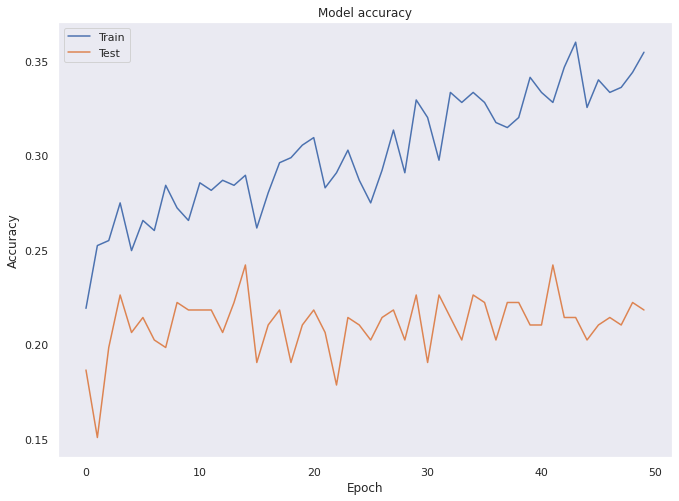

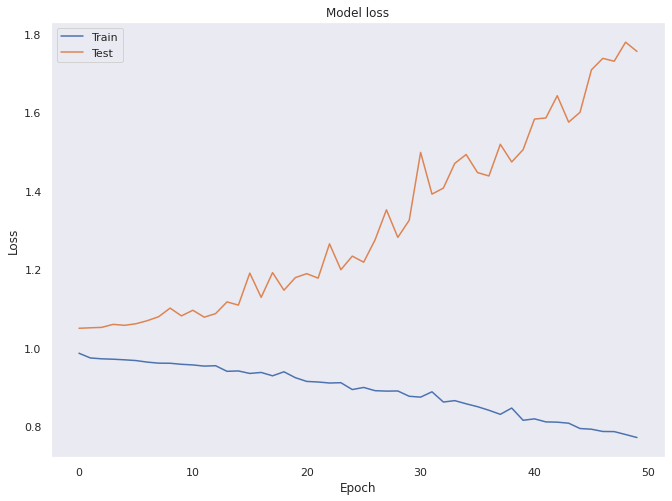

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
validation_df_0 = pd.DataFrame(columns = ['Validation Draw','Ball','Value'])
validation_df_0["Validation Draw"] = pd.to_numeric(validation_df_0["Validation Draw"])
validation_df_0["Value"] = pd.to_numeric(validation_df_0["Value"])

validation_df_1 = pd.DataFrame(columns = ['Validation Draw','Ball','Value'])
validation_df_1["Validation Draw"] = pd.to_numeric(validation_df_1["Validation Draw"])
validation_df_1["Value"] = pd.to_numeric(validation_df_1["Value"])

validation_df_3 = pd.DataFrame(columns = ['Validation Draw','Ball','Value'])
validation_df_3["Validation Draw"] = pd.to_numeric(validation_df_3["Validation Draw"])
validation_df_3["Value"] = pd.to_numeric(validation_df_3["Value"])

validation_df_6 = pd.DataFrame(columns = ['Validation Draw','Ball','Value'])
validation_df_6["Validation Draw"] = pd.to_numeric(validation_df_6["Validation Draw"])
validation_df_6["Value"] = pd.to_numeric(validation_df_6["Value"])

In [12]:
for i in range(lottery_ml.values.shape[0]-rows_to_retain_for_test, lottery_ml.values.shape[0] - games_window_size ):
    to_predict = lottery_ml.iloc[i:i+games_window_size].values.tolist()
    scaled_to_predict = scaler.transform(to_predict)
    scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))
    predicted_draw = scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0]
    actual_draw = lottery_ml.iloc[i+games_window_size].values.tolist()
    validation_df_0 = validation_df_0.append({'Validation Draw': int(i), 'Ball': "Actual", 'Value': actual_draw[0]}, ignore_index=True)
    validation_df_0 = validation_df_0.append({'Validation Draw': int(i), 'Ball': "Predicted", 'Value': predicted_draw[0] }, ignore_index=True)
    validation_df_1 = validation_df_1.append({'Validation Draw': int(i), 'Ball': "Actual", 'Value': actual_draw[1]}, ignore_index=True)
    validation_df_1 = validation_df_1.append({'Validation Draw': int(i), 'Ball': "Predicted", 'Value': predicted_draw[1] }, ignore_index=True)
    validation_df_3 = validation_df_3.append({'Validation Draw': int(i), 'Ball': "Actual", 'Value': actual_draw[3]}, ignore_index=True)
    validation_df_3 = validation_df_3.append({'Validation Draw': int(i), 'Ball': "Predicted", 'Value': predicted_draw[3] }, ignore_index=True)
    

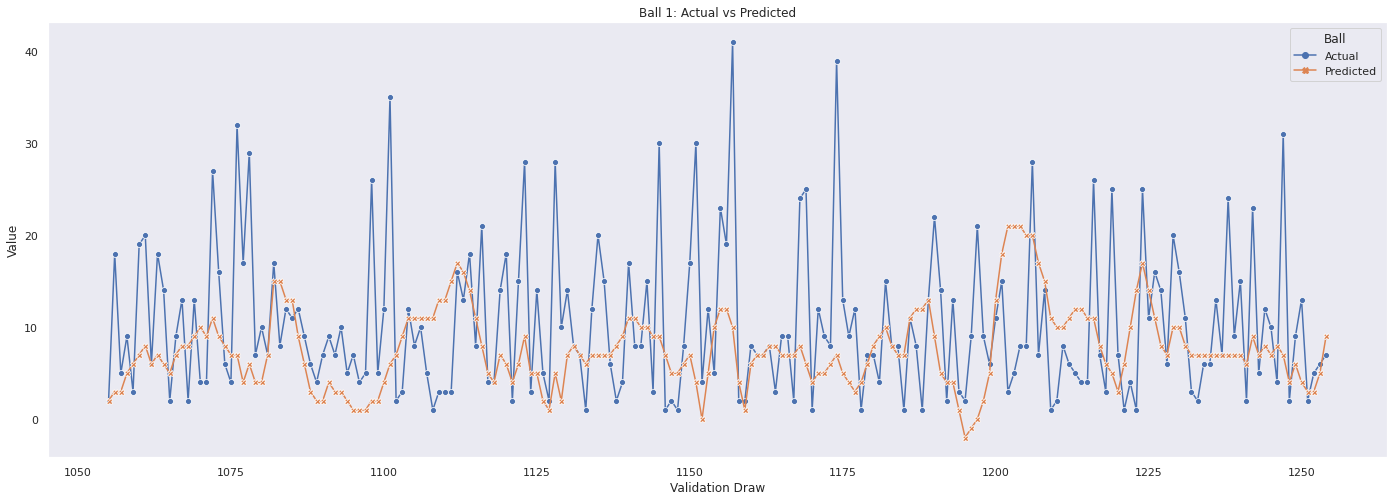

In [13]:
fig, ax = plt.subplots(figsize=(24, 8))
plt.title("Ball 1: Actual vs Predicted")
ax = sns.lineplot(x="Validation Draw", y="Value", hue="Ball",style="Ball",data=validation_df_0,markers=True, dashes=False)

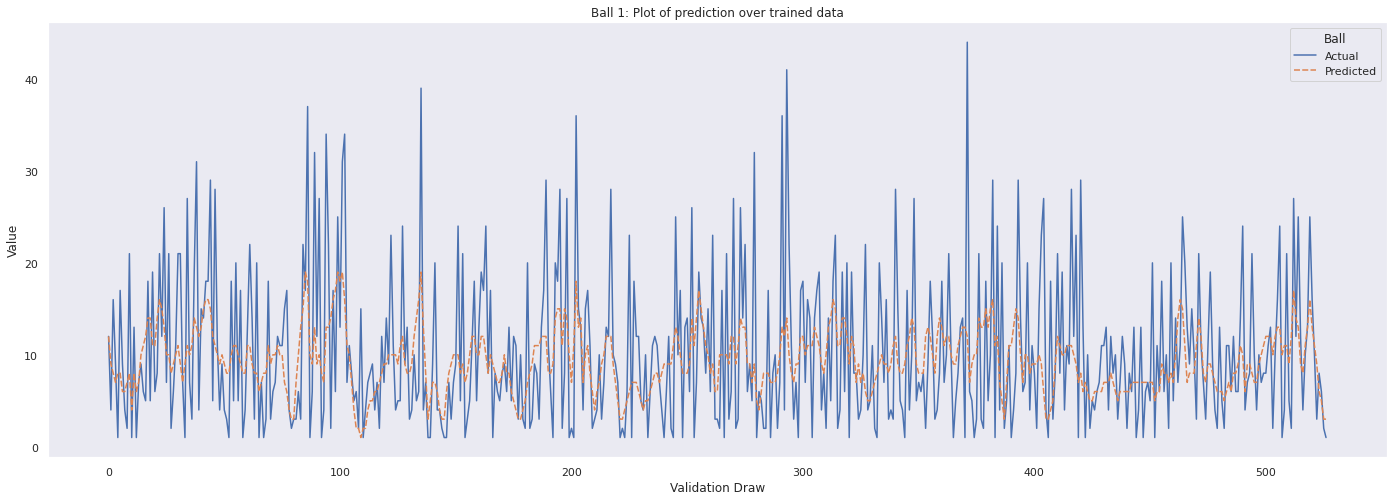

In [14]:
trained_df = pd.DataFrame(columns = ['Validation Draw','Ball','Value'])
trained_df["Validation Draw"] = pd.to_numeric(validation_df_0["Validation Draw"])
trained_df["Value"] = pd.to_numeric(trained_df["Value"])

for i in range(0, int((lottery_ml.values.shape[0]-rows_to_retain_for_test)/2)):
    to_predict = lottery_ml.iloc[i:i+games_window_size].values.tolist()
    scaled_to_predict = scaler.transform(to_predict)
    scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))
    predicted_draw = scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0]
    actual_draw = lottery_ml.iloc[i+games_window_size].values.tolist()
    trained_df = trained_df.append({'Validation Draw': int(i), 'Ball': "Actual", 'Value': actual_draw[0]}, ignore_index=True)
    trained_df = trained_df.append({'Validation Draw': int(i), 'Ball': "Predicted", 'Value': predicted_draw[0] }, ignore_index=True)
    
fig, ax = plt.subplots(figsize=(24, 8))
plt.title("Ball 1: Plot of prediction over trained data")
ax = sns.lineplot(x="Validation Draw", y="Value", hue="Ball",style="Ball",data=trained_df,markers=False, dashes=True)

## First Model was not successfull so I created a new model with more layers and more neurons

In [15]:
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

batch_size = 25 

Tensorflow version 2.6.4


In [16]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [17]:
lotto = pd.read_csv("/kaggle/input/lottery-dataset-with-dates/addeddates.csv")

In [18]:
lotto = lotto.drop(['sum'],axis=1)

In [19]:
lotto = lotto.iloc[:,1:6]

In [20]:
lotto['Ball 5'].max()

60

In [21]:
data = lotto.values

In [22]:
data

array([[ 5,  9, 25, 33, 55],
       [20, 27, 34, 57, 59],
       [ 5, 44, 45, 47, 54],
       ...,
       [ 5, 14, 48, 41, 57],
       [ 6, 20, 21, 34, 49],
       [ 7, 15, 33, 42, 53]])

In [23]:
train = data[:-50]
test = data[-50:]

w = 5
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test

In [24]:
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1201, 5)
(1146, 5, 5)
(1146, 5)
(50, 5, 5)
(50, 5)


In [25]:
embed_dim = (60 // 2) + 1
dropout_rate = 0.5
spatial_dropout_rate = 0.5
steps_before = w
steps_after = 5
feature_count = embed_dim * 5
hidden_neurons = [64, 32] 
bidirectional = True 
attention_style = 'Bahdanau'

In [26]:
with strategy.scope():
    
    inp0 = Input(shape = (w, X_train.shape[2]))
    
    # Embed 59 categories into a 30-dimension continuous-number vector for each ball
    inp1 = Lambda(lambda x: x[:, :, 0])(inp0)
    inp1 = Embedding(61, embed_dim)(inp1)
    inp1 = SpatialDropout1D(spatial_dropout_rate)(inp1)
    
    inp2 = Lambda(lambda x: x[:, :, 1])(inp0)
    inp2 = Embedding(61, embed_dim)(inp2)
    inp2 = SpatialDropout1D(spatial_dropout_rate)(inp2)
    
    inp3 = Lambda(lambda x: x[:, :, 2])(inp0)
    inp3 = Embedding(61, embed_dim)(inp3)
    inp3 = SpatialDropout1D(spatial_dropout_rate)(inp3)
    
    inp4 = Lambda(lambda x: x[:, :, 3])(inp0)
    inp4 = Embedding(61, embed_dim)(inp4)
    inp4 = SpatialDropout1D(spatial_dropout_rate)(inp4)
    
    inp5 = Lambda(lambda x: x[:, :, 4])(inp0)
    inp5 = Embedding(61, embed_dim)(inp5)
    inp5 = SpatialDropout1D(spatial_dropout_rate)(inp5)    
 
    inp = Concatenate()([inp1, inp2, inp3, inp4, inp5])
    
    # Seq2Seq model with attention or bidirectional encoder
    
    num_layers = len(hidden_neurons)
    
    sh_list, h_list, c_list = [inp], [], []
    
    if bidirectional:
        
        for i in range(num_layers):
    
            sh, fh, fc, bh, bc = Bidirectional(LSTM(hidden_neurons[i],
                                                    dropout = dropout_rate, 
                                                    return_state = True, 
                                                    return_sequences = True))(sh_list[-1])
        
            h = Concatenate()([fh, bh])
            c = Concatenate()([fc, bc]) 

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
        
    else:
    
        for i in range(num_layers):

            sh, h, c = LSTM(hidden_neurons[i], 
                            dropout = dropout_rate,
                            return_state = True, 
                            return_sequences = True)(sh_list[-1])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
    
    decoder = RepeatVector(steps_after)(h_list[-1])
    
    if bidirectional:
        
        decoder_hidden_neurons = [hn * 2 for hn in hidden_neurons]
        
    else:
        
        decoder_hidden_neurons = hidden_neurons
    
    for i in range(num_layers):
        
        decoder = LSTM(decoder_hidden_neurons[i],
                       dropout = dropout_rate, 
                       return_sequences = True)(decoder, initial_state = [h_list[i], c_list[i]])
       
    if attention_style == 'Bahdanau':
        
        context = AdditiveAttention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
        
    elif attention_style == 'Luong':
        
        context = Attention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
    
    out = Dense(61, activation = 'softmax')(decoder)

    model = Model(inputs = inp0, outputs = out)
    
    sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 5)]       0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 5)            0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 5)            0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 5)            0           input_1[0][0]                    
______________________________________________________________________________________________

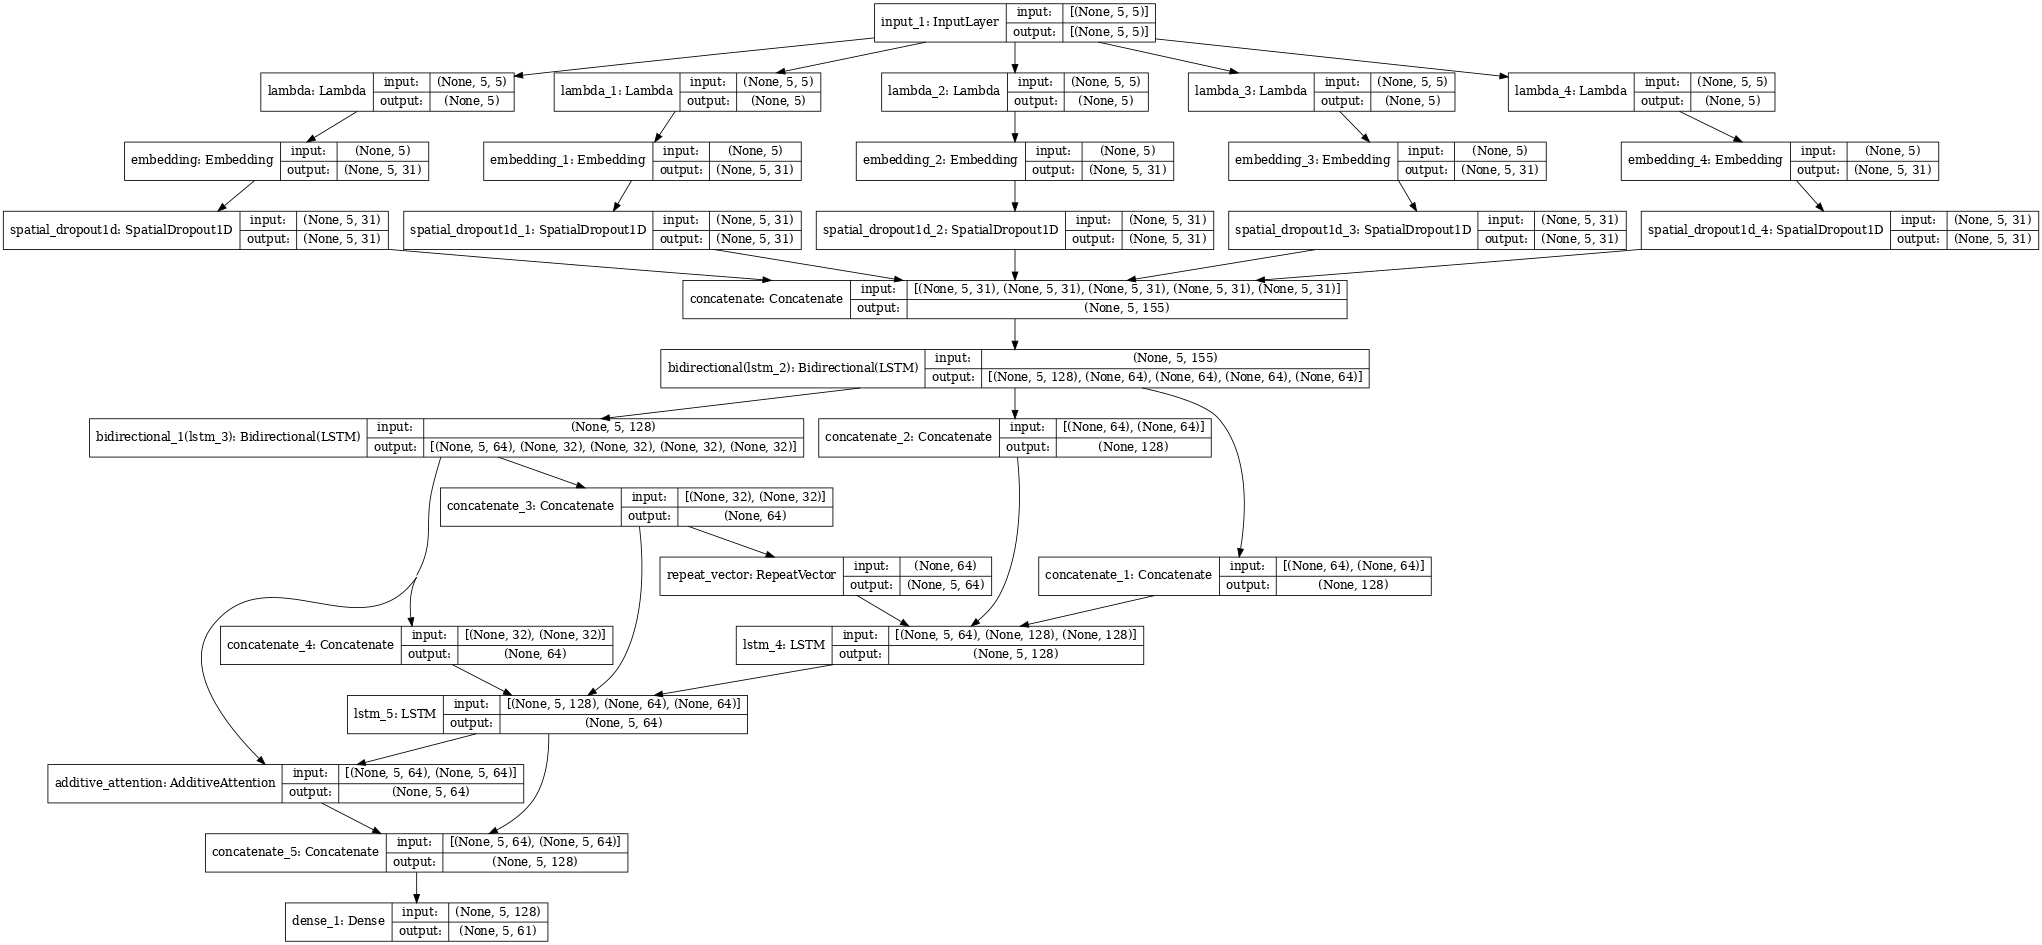

In [28]:
plot_model(model, show_shapes = True, show_layer_names = True, rankdir = 'TB', dpi = 60)

In [29]:
class CosineAnnealingScheduler(callbacks.Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min = 0, verbose = 0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)

In [30]:
EPOCHS = 25
BATCH_SIZE = 16
LR_MAX = 1e-4
LR_MIN = 1e-5

cas = CosineAnnealingScheduler(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('best_model.hdf5', monitor = 'val_sparse_top_k', verbose = 0, 
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    callbacks = [ckp, cas], 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/25


2022-09-04 14:10:36.205940: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2200 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-09-04 14:10:46.165857: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2200 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE,

72/72 - 19s - loss: 4.1104 - sparse_top_k: 0.0831 - val_loss: 4.1098 - val_sparse_top_k: 0.1000
Epoch 2/25
72/72 - 2s - loss: 4.1092 - sparse_top_k: 0.1054 - val_loss: 4.1083 - val_sparse_top_k: 0.1120
Epoch 3/25
72/72 - 2s - loss: 4.1062 - sparse_top_k: 0.1291 - val_loss: 4.1045 - val_sparse_top_k: 0.1280
Epoch 4/25
72/72 - 2s - loss: 4.0982 - sparse_top_k: 0.1394 - val_loss: 4.0863 - val_sparse_top_k: 0.1360
Epoch 5/25
72/72 - 2s - loss: 4.0259 - sparse_top_k: 0.1279 - val_loss: 3.9362 - val_sparse_top_k: 0.1160
Epoch 6/25
72/72 - 2s - loss: 3.8853 - sparse_top_k: 0.1745 - val_loss: 3.7733 - val_sparse_top_k: 0.1880
Epoch 7/25
72/72 - 2s - loss: 3.7591 - sparse_top_k: 0.2035 - val_loss: 3.6819 - val_sparse_top_k: 0.2000
Epoch 8/25
72/72 - 2s - loss: 3.7007 - sparse_top_k: 0.2122 - val_loss: 3.6336 - val_sparse_top_k: 0.2320
Epoch 9/25
72/72 - 2s - loss: 3.6676 - sparse_top_k: 0.2185 - val_loss: 3.6043 - val_sparse_top_k: 0.2280
Epoch 10/25
72/72 - 2s - loss: 3.6609 - sparse_top_k: 0.

0.2919999957084656


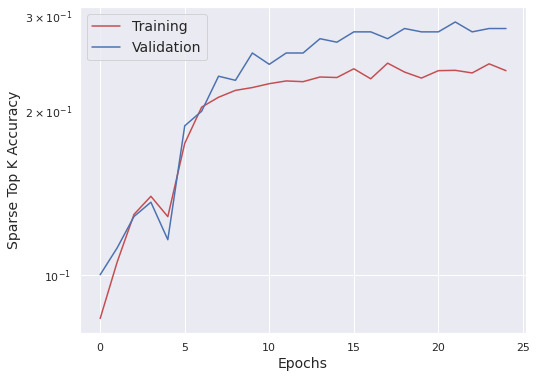

In [31]:
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

In [32]:
model.load_weights('best_model.hdf5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

2022-09-04 14:11:45.621853: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2200 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.3.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 57671680 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [33]:
pred

array([[ 1, 14, 26, 46, 59],
       [ 1, 14, 26, 46, 59],
       [ 1, 14, 26, 46, 59],
       [ 1, 14, 26, 48, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 48, 59],
       [ 1, 14, 26, 48, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 48, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 46, 59],
       [ 1, 14, 26, 46, 59],
       [ 1, 14, 26, 46, 60],
       [ 1, 14, 26, 57, 60],
       [ 1, 14, 26, 46, 59],
       [ 1, 14, 26, 48, 59],
       [ 1, 14, 26, 48, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 48, 59],
       [ 1, 14, 26, 48, 59],
       [ 1, 14, 26, 48, 59],
       [ 1, 14, 26, 48, 59],
       [ 1, 14, 26, 48, 59],
       [ 1, 14, 26, 46, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 46, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14, 26, 45, 59],
       [ 1, 14

In [34]:
for i in range(y_test.shape[0]):
    print('Prediction:\t', pred[i] + 1)
    print('GoundTruth:\t', y_test[i] + 1)
    print('-' * 40)

Prediction:	 [ 2 15 27 47 60]
GoundTruth:	 [ 9 15 43 46 59]
----------------------------------------
Prediction:	 [ 2 15 27 47 60]
GoundTruth:	 [29 32 38 48 59]
----------------------------------------
Prediction:	 [ 2 15 27 47 60]
GoundTruth:	 [ 8 21 26 43 46]
----------------------------------------
Prediction:	 [ 2 15 27 49 60]
GoundTruth:	 [15 31 35 41 49]
----------------------------------------
Prediction:	 [ 2 15 27 46 60]
GoundTruth:	 [ 2  6 12 22 34]
----------------------------------------
Prediction:	 [ 2 15 27 49 60]
GoundTruth:	 [ 3 11 16 23 30]
----------------------------------------
Prediction:	 [ 2 15 27 49 60]
GoundTruth:	 [ 9 29 36 47 58]
----------------------------------------
Prediction:	 [ 2 15 27 46 60]
GoundTruth:	 [ 7 11 19 42 51]
----------------------------------------
Prediction:	 [ 2 15 27 49 60]
GoundTruth:	 [ 6 23 24 45 60]
----------------------------------------
Prediction:	 [ 2 15 27 46 60]
GoundTruth:	 [ 5  7  8 18 47]
-------------------------------

In [35]:
X_latest = X_test[-1][1:]
X_latest = np.concatenate([X_latest, y_test[-1].reshape(1, 5)], axis = 0)
X_latest = X_latest.reshape(1, X_latest.shape[0], X_latest.shape[1])
print(X_latest + 1)

[[[14 24 38 58 61]
  [ 3 22 31 49 59]
  [ 6 15 49 42 58]
  [ 7 21 22 35 50]
  [ 8 16 34 43 54]]]


In [36]:
# beam search
def beam_search_decoder(data, k, replace = True):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            best_k = np.argsort(row)[-k:]
            for j in best_k:
                candidate = [seq + [j], score + math.log(row[j])]
                if replace:
                    all_candidates.append(candidate)
                elif (replace == False) and (len(set(candidate[0])) == len(candidate[0])):
                    all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key = lambda tup:tup[1], reverse = True)
        # select k best
        sequences = ordered[:k]
    return sequences

In [37]:
pred_latest = model.predict(X_latest)


In [38]:
pred_latest

array([[[1.49790401e-04, 7.10760131e-02, 6.27663955e-02, 5.42479083e-02,
         6.70306161e-02, 5.87951317e-02, 6.01177551e-02, 4.90850955e-02,
         5.15849032e-02, 5.15434854e-02, 4.07082215e-02, 3.96347828e-02,
         4.33048196e-02, 3.60830314e-02, 2.99985334e-02, 2.47121546e-02,
         2.02329978e-02, 1.89335532e-02, 2.23118812e-02, 1.89804751e-02,
         1.67923979e-02, 2.03467160e-02, 9.82967112e-03, 8.91783554e-03,
         1.55375320e-02, 1.07274773e-02, 7.62153696e-03, 1.17599526e-02,
         6.79800799e-03, 6.44942420e-03, 7.44861690e-03, 7.41384830e-03,
         4.56993468e-03, 4.61619254e-03, 4.14555334e-03, 4.10344219e-03,
         2.79307412e-03, 3.36525566e-03, 1.83367718e-03, 2.77686492e-03,
         3.29931919e-03, 2.07738811e-03, 2.83169840e-03, 1.76470575e-03,
         9.02299245e-04, 9.25788947e-04, 1.03680370e-03, 1.48161757e-03,
         7.13450718e-04, 6.00156724e-04, 1.01578003e-03, 6.07389899e-04,
         3.60779435e-04, 7.64475844e-04, 3.72674025

In [39]:
pred_latest = np.squeeze(pred_latest)
pred_latest_greedy = np.argmax(pred_latest, axis = 1)
print(pred_latest_greedy)

[ 1 14 26 45 59]


# End of the second model. This model was so complicated because of that it predict almost same everytime, you can use the values from it if you want but I don't suggest that

# 3. LSTM Model

In [40]:
scaler = StandardScaler().fit(lotto.values)
transformed_dataset = scaler.transform(lotto.values)
transformed_df = pd.DataFrame(data=transformed_dataset, index=lotto.index)

In [41]:
number_of_rows= lotto.values.shape[0] #all our games
window_length = 5 #amount of past games we need to take in consideration for prediction
number_of_features = lotto.values.shape[1] #balls count

In [42]:
train = np.empty([number_of_rows-window_length, window_length, number_of_features], dtype=float)
label = np.empty([number_of_rows-window_length, number_of_features], dtype=float)


for i in range(0, number_of_rows-window_length):
    train[i]=transformed_df.iloc[i:i+window_length, 0: number_of_features]
    label[i]=transformed_df.iloc[i+window_length: i+window_length+1, 0: number_of_features]

In [43]:
train.shape

(1196, 5, 5)

In [44]:
label.shape

(1196, 5)

In [45]:
train[0]

array([[-0.65528106, -1.09005079, -0.49527392, -0.70299126,  0.51475236],
       [ 1.16730475,  0.65626001,  0.31843877,  1.54047864,  0.99195621],
       [-0.65528106,  2.30555354,  1.31297651,  0.60569951,  0.3954514 ],
       [ 0.80278759, -0.21689539,  1.04173895,  0.88613325,  0.75335429],
       [-1.14130394,  0.17117368, -0.67609897, -1.07690291,  0.15684948]])

In [46]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM, Dense,Dropout

import numpy as np

batch_size = 25 

In [47]:
model = Sequential()
model.add(LSTM(32,      
           input_shape=(window_length, number_of_features),
           return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,           
           return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(number_of_features))
model.compile(loss='mse', optimizer='rmsprop') 
model.fit(train, label,
      batch_size=64, epochs=100)
model.save('input/'+filename+'.h5')

Epoch 1/100
19/19 [==============================] - 5s 10ms/step - loss: 1.0037
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 1.0009
Epoch 3/100
19/19 [==============================] - 0s 10ms/step - loss: 1.0007
Epoch 4/100
19/19 [==============================] - 0s 10ms/step - loss: 0.9991
Epoch 5/100
19/19 [==============================] - 0s 10ms/step - loss: 0.9996
Epoch 6/100
19/19 [==============================] - 0s 10ms/step - loss: 0.9982
Epoch 7/100
19/19 [==============================] - 0s 10ms/step - loss: 0.9969
Epoch 8/100
19/19 [==============================] - 0s 10ms/step - loss: 0.9984
Epoch 9/100
19/19 [==============================] - 0s 10ms/step - loss: 0.9968
Epoch 10/100
19/19 [==============================] - 0s 10ms/step - loss: 0.9975
Epoch 11/100
19/19 [==============================] - 0s 10ms/step - loss: 0.9979
Epoch 12/100
19/19 [==============================] - 0s 11ms/step - loss: 0.9963
Epoch 13/100
19/19 [=====

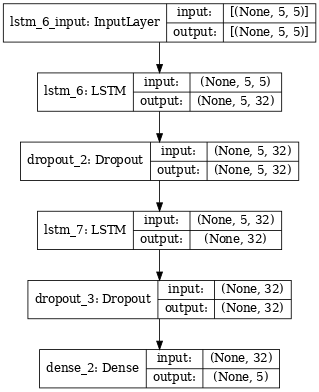

In [48]:
plot_model(model, show_shapes = True, show_layer_names = True, rankdir = 'TB', dpi = 60)

## The schema of the model

In [49]:
to_predict60 = lotto.iloc[901:1201]

In [50]:
starting = 0
j=5
list=[]
for i in range(0,60):
    
    to_pred = to_predict60.iloc[starting:j]
    j=j+5
  
    scaled_to_predict = scaler.transform(to_pred)
    scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))
    data = scaler.inverse_transform(scaled_predicted_output_1).astype(int)
    data=data.ravel()
    list.append(data)
    
    

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was

In [51]:
predsfor60day = pd.DataFrame(list)

In [52]:
predsfor60day.columns=['Ball 1','Ball 2','Ball 3','Ball 4','Ball 5']

In [53]:
predsfor60day.replace(64, 59)

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5
0,10,19,26,37,49
1,21,31,34,40,57
2,13,30,39,46,60
3,4,14,26,40,55
4,4,9,21,37,50
...,...,...,...,...,...
55,17,28,27,37,61
56,22,35,35,41,63
57,12,20,27,38,55
58,12,18,27,34,49


### From our estimations, we can say that we maintain the correlation between the 3rd and 2nd balls and the correlation between the 1st and 2nd balls, and that the incoming values increase as the ball order increases like in real draws.
### Because of these we can say 3rd model was better for this case according to first two models.

<AxesSubplot:>

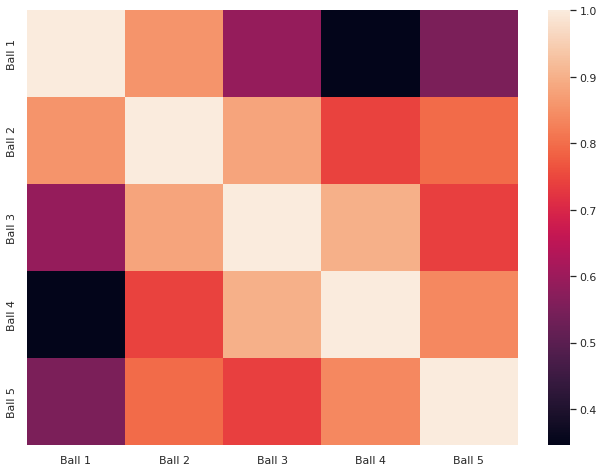

In [54]:
import seaborn as sns
sns.heatmap(predsfor60day.corr())


# Based on the statistical, time series and heuristic analyzes made at the beginning, the data does not follow a regular flow.
# But we can say that the estimates we have obtained are in accordance with the statistical inferences and the patterns that found at the beginning. Keep in mind, however, that these estimates are highly random, so they are impossible to be precise.